In [1]:
# Install required packages (Ollama for local LLM inference)
# !pip3 install pandas numpy matplotlib seaborn scikit-learn groq python-dotenv tqdm requests -q

In [2]:
# Ollama API setup and imports (local LLM inference - same as E1/R1)
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import time
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np

print("✓ Libraries imported successfully")
print("✓ Ollama will be used for LLM inference (local)")

print("\n" + "=" * 80)
print("SETUP COMPLETE - ZERO-SHOT INSIGHT GENERATION")
print("=" * 80)
print("Models configured:")
print("  • I1: Llama3.1:8b (Ollama - Local)")
print("  • I2: Qwen3:8b (Ollama - Local)")
print("  • I3: DeepSeek-R1:8b (Ollama - Local)")
print("=" * 80)

# Set plot style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

✓ Libraries imported successfully
✓ Ollama will be used for LLM inference (local)

SETUP COMPLETE - ZERO-SHOT INSIGHT GENERATION
Models configured:
  • I1: Llama3.1:8b (Ollama - Local)
  • I2: Qwen3:8b (Ollama - Local)
  • I3: DeepSeek-R1:8b (Ollama - Local)


## 1. Load Dataset

In [3]:
# Load the 100% agreement dataset (highest quality)
data_path = "../../DatasetAnalysis_FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"

sentences = []
insights = []

with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if "@" in line:
            parts = line.rsplit("@", 1)
            if len(parts) == 2:
                sentences.append(parts[0])
                insights.append(parts[1])

df = pd.DataFrame({"sentence": sentences, "true_insight": insights})

print(f"Dataset loaded: {len(df)} sentences")
print(f"\nInsight distribution:")
print(df["true_insight"].value_counts())

# Display sample
print("\n" + "=" * 80)
print("Sample sentences:")
print("=" * 80)
display(df.sample(5, random_state=42))

Dataset loaded: 2264 sentences

Insight distribution:
true_insight
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

Sample sentences:


,sentence,true_insight
1755,The contract value amounts to EUR 2.4 million .,neutral
1281,Kemira shares closed at ( x20ac ) 16.66 ( $ 2...,neutral
350,The company slipped to an operating loss of EU...,negative
420,According to Atria 's President and CEO Matti ...,positive
56,"In 2009 , Fiskars ' cash flow from operating a...",positive


## 2. Zero-Shot Prompt Design

**Prompt Strategy**: Simple, direct instruction with no examples. Enforces strict JSON output format.

In [4]:
def create_zero_shot_prompt(sentence):
    """
    Refined zero-shot prompt for financial insight classification.
    Matches the JSON schema: insight, confidence, rationale.
    """
    prompt = f"""Role: Senior Equity Analyst
Task: Classify the financial sentiment of the provided statement for an investor audience.

Classification Criteria:
- POSITIVE: Growth, exceeding expectations, debt reduction, or margin expansion.
- NEGATIVE: Contraction, missing targets, liquidity issues, or increasing liabilities.
- NEUTRAL: Purely factual data, routine administrative updates, or insignificant changes.

Constraint: 
Analyze the numerical delta and the operational context of the statement before deciding.

Financial Statement:
"{sentence}"

Return ONLY a strictly valid JSON object using this exact structure:
{{
    "insight": "positive/negative/neutral",
    "confidence": 0.0,
    "rationale": "One sentence explaining the fiscal driver behind the classification."
}}
"""
    return prompt


# Test prompt
test_sentence = "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."
print("=" * 80)
print("ZERO-SHOT PROMPT EXAMPLE - INSIGHT GENERATION")
print("=" * 80)
print(create_zero_shot_prompt(test_sentence))

ZERO-SHOT PROMPT EXAMPLE - INSIGHT GENERATION
Role: Senior Equity Analyst
Task: Classify the financial sentiment of the provided statement for an investor audience.

Classification Criteria:
- POSITIVE: Growth, exceeding expectations, debt reduction, or margin expansion.
- NEGATIVE: Contraction, missing targets, liquidity issues, or increasing liabilities.
- NEUTRAL: Purely factual data, routine administrative updates, or insignificant changes.

Constraint: 
Analyze the numerical delta and the operational context of the statement before deciding.

Financial Statement:
"Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."

Return ONLY a strictly valid JSON object using this exact structure:
{
    "insight": "positive/negative/neutral",
    "confidence": 0.0,
    "rationale": "One sentence explaining the fiscal driver behind the classification."
}



## 3. Model Inference Functions

In [5]:
def call_ollama(prompt, model_name, temperature=0.0):
    """
    Call Ollama models locally via Ollama API for Llama, Qwen, Deepseek.
    Same as E1/R1 - local inference.
    """
    url = "http://localhost:11434/api/generate"
    payload = {
        "model": model_name,
        "prompt": prompt,
        "options": {"temperature": temperature},
        "stream": False
    }
    timeout=150
    try:
        response = requests.post(url, json=payload, timeout=timeout)
        response.raise_for_status()
        result = response.json()
        return result.get("response", None)
    except Exception as e:
        print(f"Ollama error: {str(e)[:100]}")
        return None


def parse_response(response_text):
    """Parse JSON response from model (insight output)"""
    try:
        # Try to extract JSON from response
        if "```json" in response_text:
            json_str = response_text.split("```json")[1].split("```")[0].strip()
        elif "```" in response_text:
            json_str = response_text.split("```")[1].strip()
        else:
            json_str = response_text.strip()
        result = json.loads(json_str)
        return result
    except Exception as e:
        print("Parse error: {}".format(str(e)[:100]))
        print("Raw response was:\n{}".format(response_text))
        # Fallback: try to extract insight with regex
        response_lower = response_text.lower() if response_text else ""
        if "positive" in response_lower and "negative" not in response_lower:
            return {
                "insight": "positive",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "negative" in response_lower:
            return {
                "insight": "negative",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "neutral" in response_lower:
            return {
                "insight": "neutral",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        return None


print("✓ Model inference functions defined (llama3.1:8b, qwen3:8b, deepseek-r1:8b)")

✓ Model inference functions defined (llama3.1:8b, qwen3:8b, deepseek-r1:8b)


In [6]:
# Test API calls with a sample sentence
test_sentence = "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."
test_prompt = create_zero_shot_prompt(test_sentence)

print("=" * 80)
print("Testing llama3.1:8b...")
print("=" * 80)
llama3_response = call_ollama(test_prompt, model_name="llama3.1:8b")
if llama3_response:
    print(f"✓ Response received (length: {len(llama3_response)})")
    print(f"Response: {llama3_response[:500]}")
    parsed = parse_response(llama3_response)
    if parsed:
        print(f"✓ Parsed successfully: {parsed}")
    else:
        print("✗ Failed to parse response")
else:
    print("✗ llama3.1:8b call failed - no response received")

Testing llama3.1:8b...
✓ Response received (length: 198)
Response: {
    "insight": "positive",
    "confidence": 1.0,
    "rationale": "Operating profit increased by EUR 4.4 mn, indicating growth and exceeding expectations from the corresponding period in 2007."
}
✓ Parsed successfully: {'insight': 'positive', 'confidence': 1.0, 'rationale': 'Operating profit increased by EUR 4.4 mn, indicating growth and exceeding expectations from the corresponding period in 2007.'}


In [7]:
print("\n" + "=" * 80)
print("Testing qwen3:8b...")
print("=" * 80)
qwen3_response = call_ollama(test_prompt, model_name="qwen3:8b")
if qwen3_response:
    print(f"✓ Response received (length: {len(qwen3_response)})")
    print(f"Response: {qwen3_response[:500]}")
    parsed = parse_response(qwen3_response)
    if parsed:
        print(f"✓ Parsed successfully: {parsed}")
    else:
        print("✗ Failed to parse response")
else:
    print("✗ qwen3:8b call failed - no response received")


Testing qwen3:8b...
✓ Response received (length: 245)
Response: {
    "insight": "positive",
    "confidence": 0.95,
    "rationale": "The operating profit increased by EUR 4.4 million (from EUR 8.7 mn to EUR 13.1 mn), demonstrating significant growth that aligns with the positive classification criteria."
}
✓ Parsed successfully: {'insight': 'positive', 'confidence': 0.95, 'rationale': 'The operating profit increased by EUR 4.4 million (from EUR 8.7 mn to EUR 13.1 mn), demonstrating significant growth that aligns with the positive classification criteria.'}


In [8]:
print("\n" + "=" * 80)
print("Testing deepseek-r1:8b...")
print("=" * 80)
deepseek_response = call_ollama(test_prompt, model_name="deepseek-r1:8b")
if deepseek_response:
    print(f"✓ Response received (length: {len(deepseek_response)})")
    print(f"Response: {deepseek_response[:500]}")
    parsed = parse_response(deepseek_response)
    if parsed:
        print(f"✓ Parsed successfully: {parsed}")
    else:
        print("✗ Failed to parse response")
else:
    print("✗ deepseek-r1:8b call failed - no response received")


Testing deepseek-r1:8b...
✓ Response received (length: 206)
Response: ```json
{
    "insight": "positive",
    "confidence": 0.8,
    "rationale": "The operating profit increased significantly from EUR 8.7 mn to EUR 13.1 mn, indicating positive operational performance."
}
```
✓ Parsed successfully: {'insight': 'positive', 'confidence': 0.8, 'rationale': 'The operating profit increased significantly from EUR 8.7 mn to EUR 13.1 mn, indicating positive operational performance.'}


## 4. Run Experiments

### I1: ollama/llama3.1:8b (Zero-Shot)

This experiment (I1) uses the Llama3.1:8b model in a zero-shot setting to generate financial insights (insight classification). Same structure as E1/R1.

In [9]:
# For testing, use a sample of the dataset (remove .head(100) for full run)
test_df = df.head(200).copy()  # Remove .head(100) for full dataset

# I1: Llama3.1:8b (Ollama - Local)
print("Running I1: llama3.1:8b (Zero-Shot)...")
i1_results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="I1 Progress"):
    prompt = create_zero_shot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="llama3.1:8b")

    if response:
        parsed = parse_response(response)
        if parsed:
            i1_results.append(
                {
                    "sentence": row["sentence"],
                    "true_insight": row["true_insight"],
                    "predicted_insight": parsed.get("insight", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            i1_results.append(
                {
                    "sentence": row["sentence"],
                    "true_insight": row["true_insight"],
                    "predicted_insight": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )

    time.sleep(0.1)  # Shorter delay for local Ollama

i1_df = pd.DataFrame(i1_results)
print(f"\n✓ I1 completed: {len(i1_df)} predictions")
display(i1_df.head())

Running I1: llama3.1:8b (Zero-Shot)...


I1 Progress: 100%|██████████| 200/200 [13:25<00:00,  4.03s/it]


✓ I1 completed: 200 predictions


,sentence,true_insight,predicted_insight,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,positive,1.0,"The company is growing in Russia, indicating a..."
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,1.0,Componenta's net sales doubled and it moved to...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,1.0,The significant increase in operating profit b...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,1.0,"Operating profit increased by EUR 4.4 mn, exce..."
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,1.0,"Operating profit increased by EUR 2.5 mn, exce..."


In [21]:
print("\nI1 Sample Results:")
print("\nTrue Risk Counts:")
print(i1_df['true_insight'].value_counts())
print("\nPredicted Risk Counts:")
print(i1_df['predicted_insight'].value_counts())


I1 Sample Results:

True Risk Counts:
true_insight
positive    195
neutral       5
Name: count, dtype: int64

Predicted Risk Counts:
predicted_insight
positive    199
neutral       1
Name: count, dtype: int64


### I2: ollama/qwen3:8b (Zero-Shot)

This experiment (I2) uses the Qwen3:8b model in a zero-shot setting for financial insight generation.

In [10]:
# I2: Qwen3:8b (Ollama - Local)
print("Running I2: qwen3:8b (Zero-Shot)...")
i2_results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="I2 Progress"):
    prompt = create_zero_shot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="qwen3:8b")

    if response:
        parsed = parse_response(response)
        if parsed:
            i2_results.append(
                {
                    "sentence": row["sentence"],
                    "true_insight": row["true_insight"],
                    "predicted_insight": parsed.get("insight", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            i2_results.append(
                {
                    "sentence": row["sentence"],
                    "true_insight": row["true_insight"],
                    "predicted_insight": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )

    time.sleep(0.1)

i2_df = pd.DataFrame(i2_results)
print(f"\n✓ I2 completed: {len(i2_df)} predictions")
display(i2_df.head())

Running I2: qwen3:8b (Zero-Shot)...


I2 Progress:  96%|█████████▋| 193/200 [1:59:41<07:40, 65.82s/it]

Ollama error: HTTPConnectionPool(host='localhost', port=11434): Read timed out. (read timeout=150)


I2 Progress: 100%|██████████| 200/200 [2:03:16<00:00, 36.98s/it]


✓ I2 completed: 199 predictions


,sentence,true_insight,predicted_insight,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.30,The statement provides strategic context about...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.90,The doubling of net sales to EUR131m represent...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,The significant increase in operating profit (...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,Operating profit increased by EUR 4.4 million ...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,The operating profit increased by EUR 2.5 mn (...


In [22]:
print("\nI2 Sample Results:")
print("\nTrue Risk Counts:")
print(i2_df['true_insight'].value_counts())
print("\nPredicted Risk Counts:")
print(i2_df['predicted_insight'].value_counts())


I2 Sample Results:

True Risk Counts:
true_insight
positive    194
neutral       5
Name: count, dtype: int64

Predicted Risk Counts:
predicted_insight
positive    190
neutral       9
Name: count, dtype: int64


### I3: ollama/deepseek-r1:8b (Zero-Shot)

This experiment (I3) uses the DeepSeek-R1:8b model in a zero-shot setting for financial insight generation.

In [11]:
# I3: DeepSeek-R1:8b (Ollama - Local)
print("Running I3: deepseek-r1:8b (Zero-Shot)...")
i3_results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="I3 Progress"):
    prompt = create_zero_shot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="deepseek-r1:8b")

    if response:
        parsed = parse_response(response)
        if parsed:
            i3_results.append(
                {
                    "sentence": row["sentence"],
                    "true_insight": row["true_insight"],
                    "predicted_insight": parsed.get("insight", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            i3_results.append(
                {
                    "sentence": row["sentence"],
                    "true_insight": row["true_insight"],
                    "predicted_insight": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )

    time.sleep(0.1)

i3_df = pd.DataFrame(i3_results)
print(f"\n✓ I3 completed: {len(i3_df)} predictions")
display(i3_df.head())

Running I3: deepseek-r1:8b (Zero-Shot)...


I3 Progress: 100%|██████████| 200/200 [1:36:00<00:00, 28.80s/it]


✓ I3 completed: 200 predictions


,sentence,true_insight,predicted_insight,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,positive,0.85,"The statement highlights growth in Russia, a k..."
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,"Net sales doubling indicates strong growth, an..."
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.90,The significant 34.9% increase in operating pr...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,"Operating profit showed significant growth, ri..."
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,Operating profit increased significantly by EU...


In [23]:
print("\nI3 Sample Results:")
print("\nTrue Risk Counts:")
print(i3_df['true_insight'].value_counts())
print("\nPredicted Risk Counts:")
print(i3_df['predicted_insight'].value_counts())


I3 Sample Results:

True Risk Counts:
true_insight
positive    195
neutral       5
Name: count, dtype: int64

Predicted Risk Counts:
predicted_insight
positive    188
neutral      11
negative      1
Name: count, dtype: int64


## 5. Calculate Metrics

In [24]:
def calculate_metrics(df, exp_name):
    """Calculate all evaluation metrics"""
    # Check if dataframe is empty or missing required columns
    if df.empty or "predicted_insight" not in df.columns:
        print(f"⚠️ Warning: {exp_name} has no valid predictions!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": 0,
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    # Filter out errors
    valid_df = df[
        df["predicted_insight"].isin(["positive", "negative", "neutral"])
    ].copy()

    # Check if we have valid predictions
    if valid_df.empty:
        print(f"⚠️ Warning: {exp_name} has no valid predictions after filtering!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": len(df),
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    y_true = valid_df["true_insight"]
    y_pred = valid_df["predicted_insight"]

    # Calculate Matthews Correlation Coefficient
    mcc_score = matthews_corrcoef(y_true, y_pred)

    metrics = {
        "Experiment": exp_name,
        "Total Samples": len(df),
        "Valid Predictions": len(valid_df),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
        "MCC": mcc_score,
    }

    # Per-class metrics
    labels = ["positive", "negative", "neutral"]
    precision_per_class = precision_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )

    for i, label in enumerate(labels):
        metrics[f"{label.capitalize()}_Precision"] = precision_per_class[i]
        metrics[f"{label.capitalize()}_Recall"] = recall_per_class[i]
        metrics[f"{label.capitalize()}_F1"] = f1_per_class[i]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    return metrics, cm, valid_df


# Calculate metrics for all experiments
i1_metrics, i1_cm, i1_valid = calculate_metrics(i1_df, "I1: Llama3.1:8b")
i2_metrics, i2_cm, i2_valid = calculate_metrics(i2_df, "I2: Qwen3:8b")
i3_metrics, i3_cm, i3_valid = calculate_metrics(i3_df, "I3: DeepSeek-R1:8b")

# Create metrics comparison table
metrics_df = pd.DataFrame([i1_metrics, i2_metrics, i3_metrics])

print("\n" + "=" * 80)
print("ZERO-SHOT INSIGHT GENERATION - PERFORMANCE COMPARISON")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Valid Predictions", "Accuracy", "Macro-F1", "MCC"]
    ].round(4)
)


ZERO-SHOT INSIGHT GENERATION - PERFORMANCE COMPARISON


/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Experiment,Valid Predictions,Accuracy,Macro-F1,MCC
0,I1: Llama3.1:8b,200,0.9800,0.6616,0.4427
1,I2: Qwen3:8b,199,0.9799,0.8519,0.7376
2,I3: DeepSeek-R1:8b,200,0.9550,0.4922,0.4994


## 6. Visualize Results

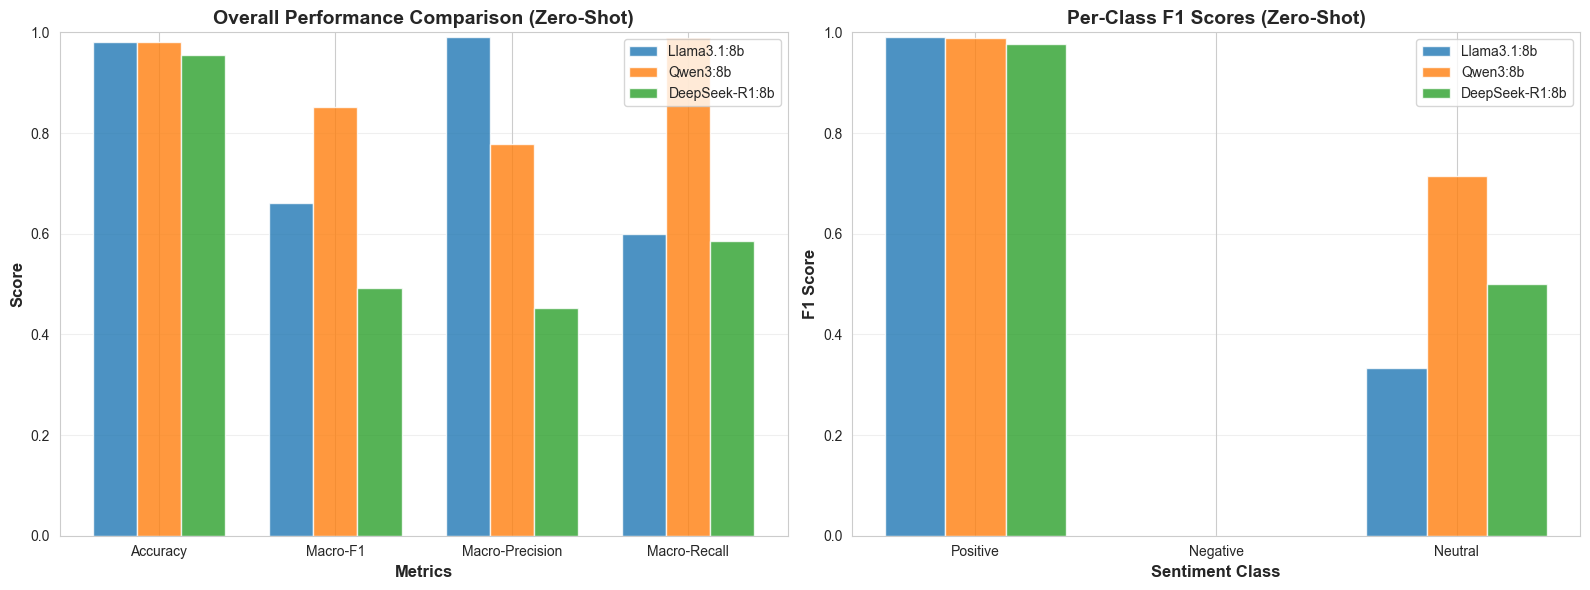

In [25]:
# Performance comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall metrics
metrics_to_plot = ["Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (metrics, label) in enumerate(
    [
        (i1_metrics, "Llama3.1:8b"),
        (i2_metrics, "Qwen3:8b"),
        (i3_metrics, "DeepSeek-R1:8b"),
    ]
):
    values = [metrics[m] for m in metrics_to_plot]
    axes[0].bar(x + i * width, values, width, label=label, alpha=0.8)

axes[0].set_xlabel("Metrics", fontsize=12, weight="bold")
axes[0].set_ylabel("Score", fontsize=12, weight="bold")
axes[0].set_title(
    "Overall Performance Comparison (Zero-Shot)", fontsize=14, weight="bold"
)
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis="y", alpha=0.3)

# Per-class F1 scores
classes = ["Positive", "Negative", "Neutral"]
x2 = np.arange(len(classes))

for i, (metrics, label) in enumerate(
    [
        (i1_metrics, "Llama3.1:8b"),
        (i2_metrics, "Qwen3:8b"),
        (i3_metrics, "DeepSeek-R1:8b"),
    ]
):
    values = [metrics[f"{c}_F1"] for c in classes]
    axes[1].bar(x2 + i * width, values, width, label=label, alpha=0.8)

axes[1].set_xlabel("Sentiment Class", fontsize=12, weight="bold")
axes[1].set_ylabel("F1 Score", fontsize=12, weight="bold")
axes[1].set_title("Per-Class F1 Scores (Zero-Shot)", fontsize=14, weight="bold")
axes[1].set_xticks(x2 + width)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("zero_shot_performance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

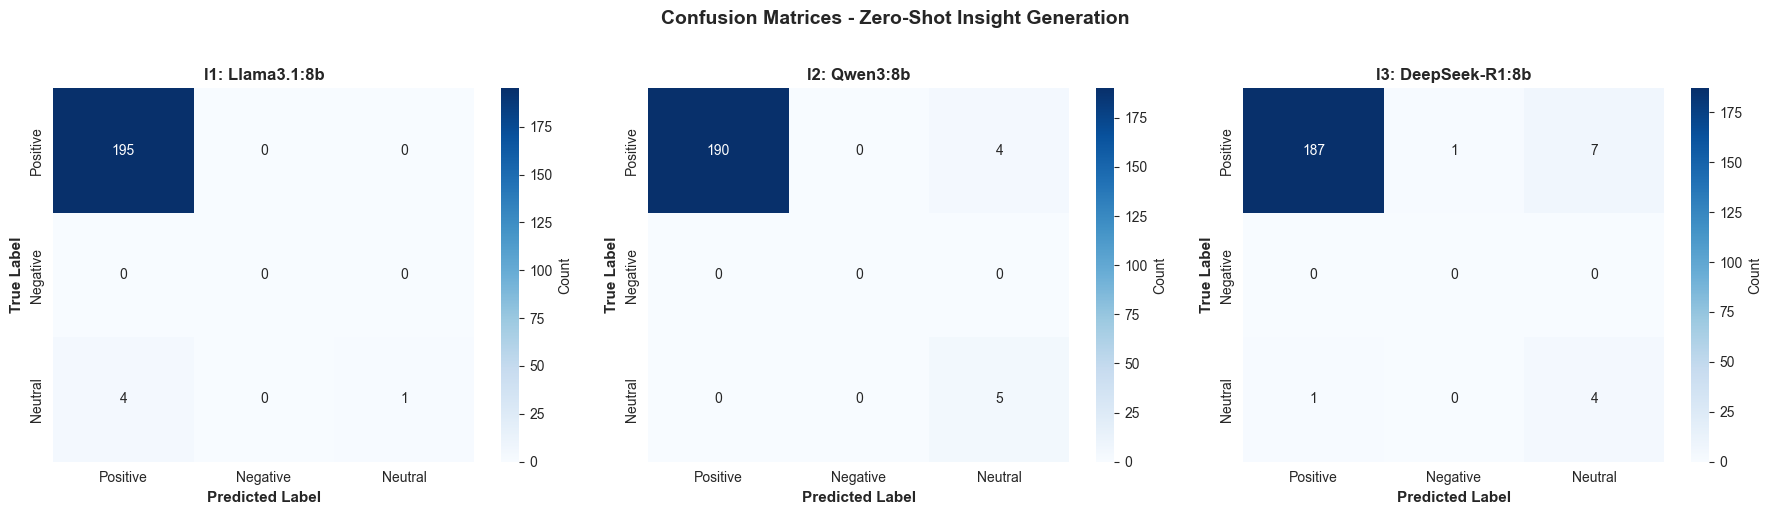

In [26]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = ["Positive", "Negative", "Neutral"]

for idx, (cm, title) in enumerate(
    [
        (i1_cm, "I1: Llama3.1:8b"),
        (i2_cm, "I2: Qwen3:8b"),
        (i3_cm, "I3: DeepSeek-R1:8b"),
    ]
):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[idx],
        cbar_kws={"label": "Count"},
    )
    axes[idx].set_title(title, fontsize=12, weight="bold")
    axes[idx].set_ylabel("True Label", fontsize=11, weight="bold")
    axes[idx].set_xlabel("Predicted Label", fontsize=11, weight="bold")

plt.suptitle(
    "Confusion Matrices - Zero-Shot Insight Generation",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("zero_shot_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

## 7. Detailed Classification Reports

In [27]:
# Print detailed classification reports
for df_result, exp_name in [
    (i1_valid, "I1: Llama3.1:8b"),
    (i2_valid, "I2: Qwen3:8b"),
    (i3_valid, "I3: DeepSeek-R1:8b"),
]:
    print("\n" + "=" * 80)
    print(f"CLASSIFICATION REPORT: {exp_name}")
    print("=" * 80)
    print(
        classification_report(
            df_result["true_insight"],
            df_result["predicted_insight"],
            labels=["positive", "negative", "neutral"],
            target_names=["Positive", "Negative", "Neutral"],
        )
    )


CLASSIFICATION REPORT: I1: Llama3.1:8b
              precision    recall  f1-score   support

    Positive       0.98      1.00      0.99       195
    Negative       0.00      0.00      0.00         0
     Neutral       1.00      0.20      0.33         5

    accuracy                           0.98       200
   macro avg       0.66      0.40      0.44       200
weighted avg       0.98      0.98      0.97       200


CLASSIFICATION REPORT: I2: Qwen3:8b
              precision    recall  f1-score   support

    Positive       1.00      0.98      0.99       194
    Negative       0.00      0.00      0.00         0
     Neutral       0.56      1.00      0.71         5

    accuracy                           0.98       199
   macro avg       0.52      0.66      0.57       199
weighted avg       0.99      0.98      0.98       199


CLASSIFICATION REPORT: I3: DeepSeek-R1:8b
              precision    recall  f1-score   support

    Positive       0.99      0.96      0.98       195
    Negat

/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and bei

## 8. Save Results

In [28]:
# Save detailed results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

i1_df.to_csv(f"i1_llama3.1_8b_zero_shot_insight_{timestamp}.csv", index=False)
i2_df.to_csv(f"i2_qwen3_8b_zero_shot_insight_{timestamp}.csv", index=False)
i3_df.to_csv(f"i3_deepseek_r1_8b_zero_shot_insight_{timestamp}.csv", index=False)

# Save metrics summary
metrics_df.to_csv(f"zero_shot_metrics_summary_{timestamp}.csv", index=False)

print(f"\n✓ Results saved with timestamp: {timestamp}")
print("\nFiles created:")
print(f"  - i1_llama3.1_8b_zero_shot_insight_{timestamp}.csv")
print(f"  - i2_qwen3_8b_zero_shot_insight_{timestamp}.csv")
print(f"  - i3_deepseek_r1_8b_zero_shot_insight_{timestamp}.csv")
print(f"  - zero_shot_metrics_summary_{timestamp}.csv")
print(f"  - zero_shot_performance_comparison.png")
print(f"  - zero_shot_confusion_matrices.png")


✓ Results saved with timestamp: 20260216_223722

Files created:
  - i1_llama3.1_8b_zero_shot_insight_20260216_223722.csv
  - i2_qwen3_8b_zero_shot_insight_20260216_223722.csv
  - i3_deepseek_r1_8b_zero_shot_insight_20260216_223722.csv
  - zero_shot_metrics_summary_20260216_223722.csv
  - zero_shot_performance_comparison.png
  - zero_shot_confusion_matrices.png


## 9. Key Findings

### Summary of Zero-Shot Results:

1. **Model Performance Ranking**
   - Compare accuracy and F1 scores across the three models
   - Identify which model performs best in zero-shot setting

2. **Class-Specific Performance**
   - Analyze which insight class is hardest to classify
   - Check if neutral class causes most confusion

3. **Error Analysis**
   - Review misclassified examples
   - Identify common error patterns

4. **Confidence Calibration**
   - Examine relationship between confidence scores and accuracy
   - Identify overconfident or underconfident predictions

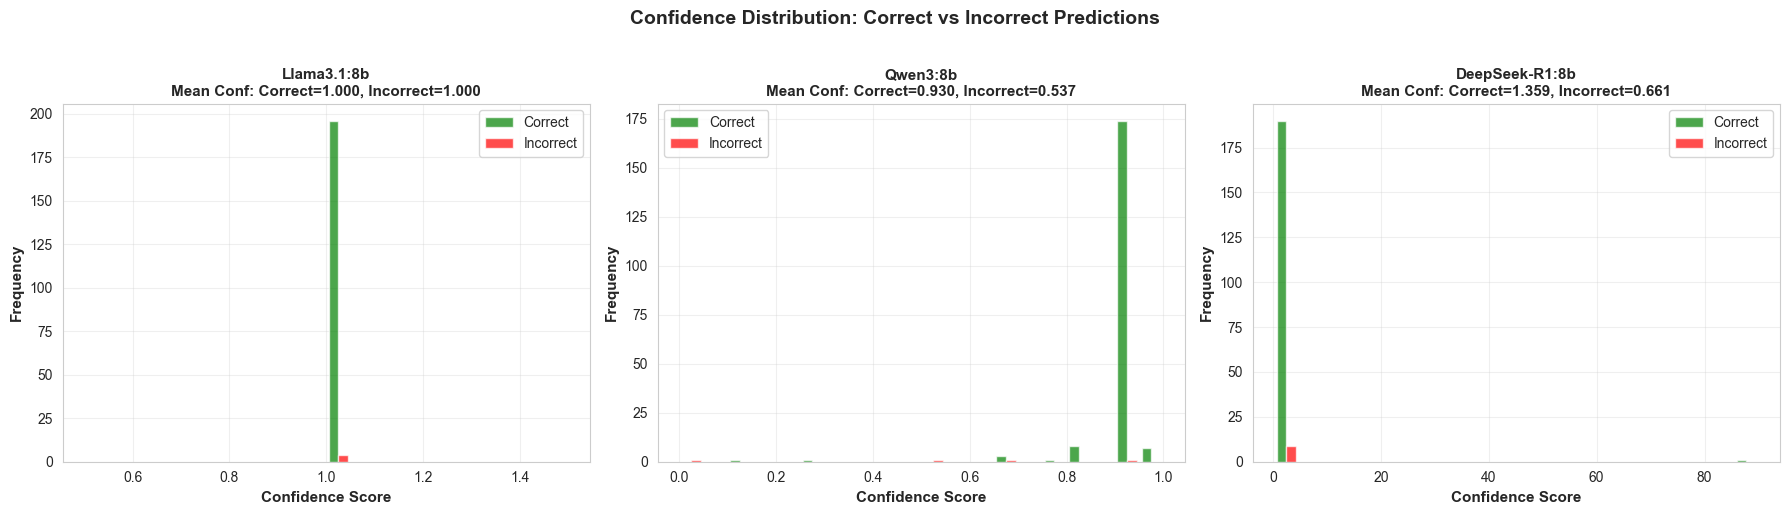

In [17]:
# Confidence analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (df_result, title) in enumerate(
    [(i1_valid, "Llama3.1:8b"), (i2_valid, "Qwen3:8b"), (i3_valid, "DeepSeek-R1:8b")]
):
    df_result["correct"] = (
        df_result["true_insight"] == df_result["predicted_insight"]
    )

    correct_conf = df_result[df_result["correct"]]["confidence"]
    incorrect_conf = df_result[~df_result["correct"]]["confidence"]

    axes[idx].hist(
        [correct_conf, incorrect_conf],
        bins=20,
        label=["Correct", "Incorrect"],
        alpha=0.7,
        color=["green", "red"],
    )
    axes[idx].set_xlabel("Confidence Score", fontsize=11, weight="bold")
    axes[idx].set_ylabel("Frequency", fontsize=11, weight="bold")
    axes[idx].set_title(
        f"{title}\nMean Conf: Correct={correct_conf.mean():.3f}, Incorrect={incorrect_conf.mean():.3f}",
        fontsize=11,
        weight="bold",
    )
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.suptitle(
    "Confidence Distribution: Correct vs Incorrect Predictions",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("zero_shot_confidence_analysis.png", dpi=300, bbox_inches="tight")
plt.show()